In [34]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from Utils import *
from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## get the dataset

In [35]:
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)
results = {}

## Constants

In [36]:
SIZE_RESERVOIR = 200
LAMBDA_REG = 0.01
MAX_ITER = 2000
PRECISION = 1e-6
LR = 0 # 1/(L+tau) will be chosen if LR=0

## fix the resevoir

In [37]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))

In [38]:
H = sigmoid(resevoir@tr_x)

In [39]:
condition_number = np.linalg.cond(H)
print(f"Condition number of H: {condition_number}")

Condition number of H: 2428.8963541983067


# OPTIMAL SOLUTION

In [40]:
w_star,_,_,_ = np.linalg.lstsq(H.T, tr_y.T,rcond=-1)
optimal_mse, optimal_residual = mse(w_star.T@H,tr_y), get_residual_y(tr_y,w_star.T@H)
results["optimal"] = (optimal_mse, optimal_residual)

In [41]:
print("Mean square error: ", optimal_mse)
print("Relative Gap Pred: ", optimal_residual)

Mean square error:  1.324121445875068
Relative Gap Pred:  0.07492904931464638


## Cholesky solution

In [42]:
model = fit_cholesky(tr_x,tr_y, lambda_=LAMBDA_REG, activation="sig", resevoir=resevoir)
mse_cholesky, residual_cholesky = get_results(model,tr_x,tr_y)
results["cholesky"] = (mse_cholesky, residual_cholesky)

In [43]:
a = np.linalg.norm(model.w2 - w_star.T)/np.linalg.norm(w_star)
print("Relative Gap Sol: ", a)

Relative Gap Sol:  0.24093153506561046


In [44]:
print("Mean square error: ", mse_cholesky)
print("Relative Gap Pred: ", residual_cholesky)

Mean square error:  1.3296632551583951
Relative Gap Pred:  0.0750856848458629


## Iterative methods

In [45]:
classical_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                        eps=PRECISION, lr=LR, beta=0, resevoir=resevoir, minimum=optimal_mse, w_star=w_star.T)
mse_classical_sgd, residual_classical_sgd = get_results(classical_sgd[0],tr_x,tr_y)
results["classical-SGD"] = (mse_classical_sgd, residual_classical_sgd)

SGD max iterations reached


In [46]:
momentum_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                       eps=PRECISION, lr=0, beta=0.99, resevoir=resevoir, minimum=optimal_mse, w_star=w_star.T)
mse_momentum_sgd, residual_momentum_sgd = get_results(momentum_sgd[0],tr_x,tr_y)
results["momentum-SGD"] = (mse_momentum_sgd, residual_momentum_sgd)

SGD max iterations reached


In [47]:
fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, activation="sig", max_inters=MAX_ITER,
                      eps=PRECISION, resevoir=resevoir, minimum=optimal_mse, w_star=w_star.T)
mse_fista, residual_fista = get_results(fista[0],tr_x,tr_y)
results["fista"] = (mse_fista, residual_fista)

FISTA max iterations reached


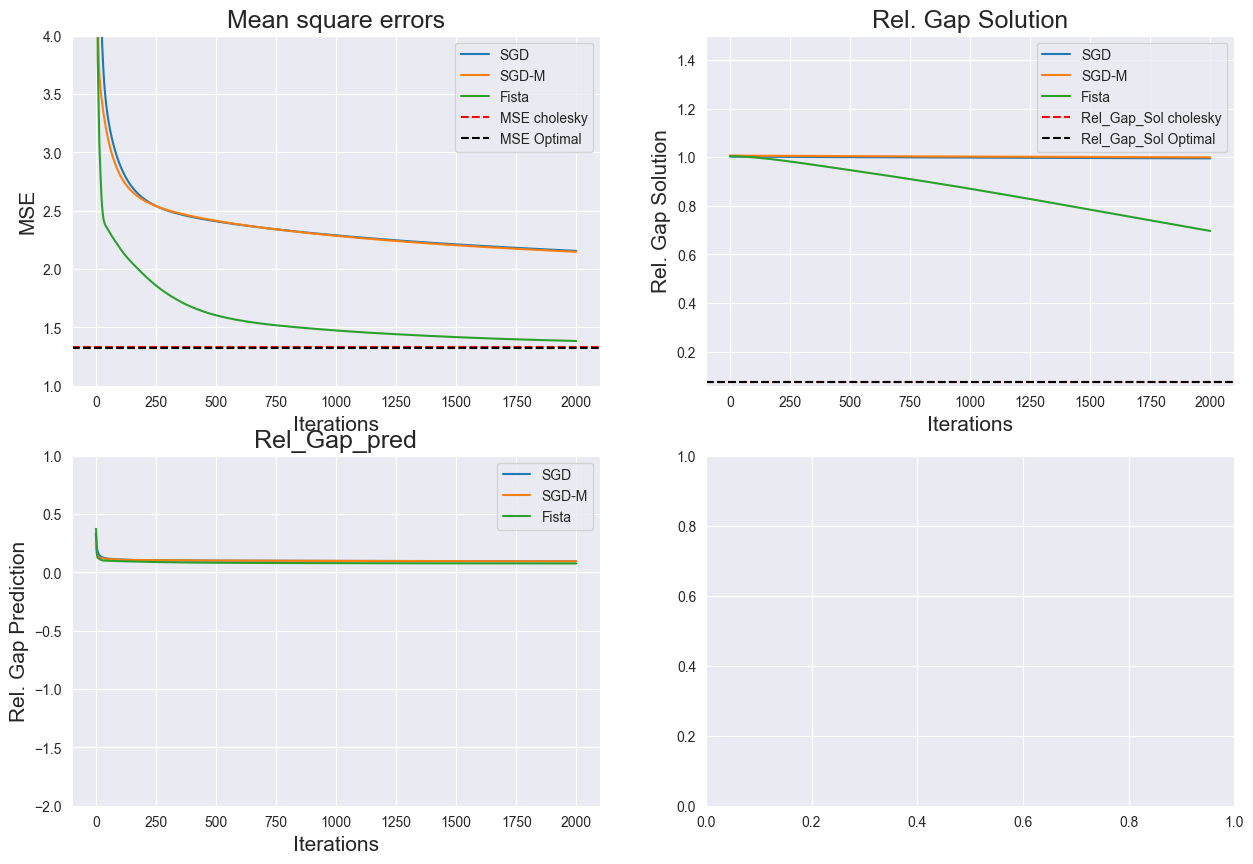

In [49]:
_, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="MSE", ax=axs[0,0], label="SGD")
sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="MSE", ax=axs[0,0], label="SGD-M")
sns.lineplot(data=fista[1], x=fista[1].index, y="MSE", ax=axs[0,0], label="Fista")
axs[0,0].axhline(y=mse_cholesky, label="MSE cholesky", color="red", linestyle="--")
axs[0,0].axhline(y=optimal_mse, label="MSE Optimal", color="black", linestyle="--")
axs[0,0].set_title("Mean square errors",fontsize=18)
axs[0,0].set_ylabel("MSE",fontsize=15)
axs[0,0].set_xlabel("Iterations",fontsize=15)
axs[0,0].set_ylim([1,4])
axs[0,0].legend()

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="Rel_Gap_Sol", ax=axs[0,1], label="SGD")
sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="Rel_Gap_Sol", ax=axs[0,1], label="SGD-M")
sns.lineplot(data=fista[1], x=fista[1].index, y="Rel_Gap_Sol", ax=axs[0,1], label="Fista")
axs[0,1].axhline(y=residual_cholesky, label="Rel_Gap_Sol cholesky", color="red", linestyle="--")
axs[0,1].axhline(y=optimal_residual, label="Rel_Gap_Sol Optimal", color="black", linestyle="--")
axs[0,1].set_title("Rel. Gap Solution",fontsize=18)
axs[0,1].set_ylabel("Rel. Gap Solution",fontsize=15)
axs[0,1].set_xlabel("Iterations",fontsize=15)
axs[0,1].set_ylim([0.06,1.5])
axs[0,1].legend()

sns.lineplot(data=classical_sgd[1], x=classical_sgd[1].index, y="Rel_Gap_pred", ax=axs[1,0], label="SGD")
sns.lineplot(data=momentum_sgd[1], x=momentum_sgd[1].index, y="Rel_Gap_pred", ax=axs[1,0], label="SGD-M")
sns.lineplot(data=fista[1], x=fista[1].index, y="Rel_Gap_pred", ax=axs[1,0], label="Fista")
axs[1,0].set_title("Rel_Gap_pred",fontsize=18)
axs[1,0].set_ylabel("Rel. Gap Prediction",fontsize=15)
axs[1,0].set_xlabel("Iterations",fontsize=15)
axs[1,0].set_ylim([-2,1])
axs[1,0].legend()


plt.show()

In [51]:
print(f"{'Method' : ^20}{'MSE' : ^12}{'Residual' : ^12}")

for k,v in results.items():
    print(f"{k : ^20}{round(v[0],4):^12}{round(v[1],5) : ^12}")

       Method           MSE       Residual  
      optimal          1.3241     0.07493   
      cholesky         1.3297     0.07509   
   classical-SGD       2.1559     0.09561   
    momentum-SGD       2.1478     0.09543   
       fista           1.3834     0.07659   
